In [ ]:
onColab = True
model_path = './withoutlrr'

# Decide batch size and validation split
batch_size = 16
validation_split = 0.2
test_split = 0.01
epochs = 200

dataset_path = './Training_smooth4.csv'

window = 600
stride = 20
# 864 / 8
telescope = 108

## Init
Initialize codalab, libraries and seed

In [ ]:
#@title connect to codalab
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE2


In [ ]:
#@title Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

tf.config.list_physical_devices('GPU')

2.7.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Dataset import and manipulation

In [ ]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.describe()

(68480, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000
mean,6.092920,4.695038,13.338328,2.448571,2.406236,23.226083,8.233430
std,1.850374,3.276466,11.400923,2.913896,0.977233,14.266769,11.008436
min,0.373821,-7.078339,-38.472928,-9.010756,-1.112682,-5.957617,-42.243983
25%,4.904697,2.311735,10.714054,0.459732,2.141207,12.586388,6.350049
50%,5.716294,4.707046,15.650564,2.624066,2.617749,20.122389,10.980270
75%,6.983160,7.004572,20.341672,4.606686,2.981460,31.173663,15.216130
max,15.390880,17.665553,38.461400,13.891042,4.938068,76.363976,28.687612


In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
# inspect_dataframe(dataset, dataset.columns)

In [ ]:
def normalize(dataset, t=None):
  if t is None or t == 'minmax':
    x_min = dataset.min(axis=0)
    print(x_min.shape)
    x_max = dataset.max()
    nd = (dataset - x_min) / (x_max - x_min)
    return nd
  elif t == 'mean_std':
    x_mean = dataset.mean()
    x_std = dataset.std()
    nd = (dataset - x_mean) / x_std
    return nd

In [ ]:
normalized_ds = normalize(dataset)
normalized_ds.describe()

(7,)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000
mean,0.380840,0.475809,0.673448,0.500368,0.581567,0.354508,0.711635
std,0.123218,0.132415,0.148190,0.127234,0.161506,0.173305,0.155198
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.301715,0.379491,0.639337,0.413526,0.537766,0.225263,0.685083
50%,0.355760,0.476295,0.703503,0.508031,0.616524,0.316806,0.750360
75%,0.440122,0.569147,0.764478,0.594601,0.676634,0.451052,0.810078
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
def chunk(dataset, window, telescope, stride):
  """
  divide the dataset in chunks. 
  It keeps the right-most elements and discard the left ones, if size and stride are not compatible with dimensions. 
  """
  size = window + telescope
  X = []
  Y = []
  for i in range(len(dataset) - size, -1, -stride):
    X.append(dataset[i: i + window])
    Y.append(dataset[i + window: i + size])
  X.reverse()
  Y.reverse()
  return (np.array(X), np.array(Y))

In [ ]:
x, y = chunk(normalized_ds, window, telescope, stride)

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
# shuffle data so that 
x, y = sklearn.utils.shuffle(x, y, random_state=seed)
x.shape, y.shape

((3389, 600, 7), (3389, 108, 7))

In [ ]:
inspect_multivariate(x, y, dataset.columns, telescope, 4500)

## Model
build the model and learn

In [ ]:
input_shape = (window, 7)
output_shape = (telescope, 7)

In [ ]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # E1D1
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]

    #
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))    
    conv = tfkl.Conv1D(512, 3, padding='same', activation='relu')
    encoder_l1 = tf.keras.layers.LSTM(256, return_state=True)
    encoder_outputs1 = encoder_l1(conv(encoder_inputs))

    encoder_states1 = encoder_outputs1[1:]

    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

    #
    decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

    #
    model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    model_e1d1.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(lr=0.001), metrics=['mae'])

    return model_e1d1

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 600, 7)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 600, 512)     11264       ['input_2[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        787456      ['conv1d_1[0][0]']               
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

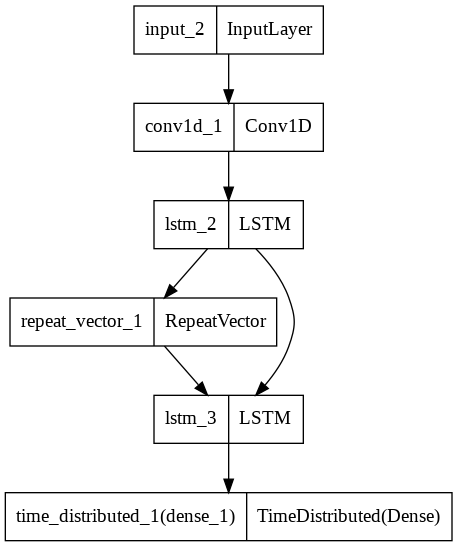

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = x,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True),
        tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/200
170/170 [==============================] - ETA: 0s - loss: 0.0172 - mae: 0.0905

170/170 [==============================] - 59s 274ms/step - loss: 0.0172 - mae: 0.0905 - val_loss: 0.0112 - val_mae: 0.0748
Epoch 2/200
170/170 [==============================] - ETA: 0s - loss: 0.0110 - mae: 0.0741

170/170 [==============================] - 45s 267ms/step - loss: 0.0110 - mae: 0.0741 - val_loss: 0.0108 - val_mae: 0.0756
Epoch 3/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0106 - mae: 0.0727 - val_loss: 0.0109 - val_mae: 0.0762
Epoch 4/200
170/170 [==============================] - ETA: 0s - loss: 0.0104 - mae: 0.0717

170/170 [==============================] - 45s 267ms/step - loss: 0.0104 - mae: 0.0717 - val_loss: 0.0104 - val_mae: 0.0711
Epoch 5/200
170/170 [==============================] - ETA: 0s - loss: 0.0101 - mae: 0.0711

170/170 [==============================] - 46s 269ms/step - loss: 0.0101 - mae: 0.0711 - val_loss: 0.0102 - val_mae: 0.0733
Epoch 6/200
170/170 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0696

170/170 [==============================] - 45s 268ms/step - loss: 0.0096 - mae: 0.0696 - val_loss: 0.0092 - val_mae: 0.0685
Epoch 7/200
170/170 [==============================] - ETA: 0s - loss: 0.0080 - mae: 0.0643

170/170 [==============================] - 45s 267ms/step - loss: 0.0080 - mae: 0.0643 - val_loss: 0.0075 - val_mae: 0.0618
Epoch 8/200
170/170 [==============================] - ETA: 0s - loss: 0.0070 - mae: 0.0604

170/170 [==============================] - 47s 278ms/step - loss: 0.0070 - mae: 0.0604 - val_loss: 0.0066 - val_mae: 0.0574
Epoch 9/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0066 - mae: 0.0584 - val_loss: 0.0072 - val_mae: 0.0625
Epoch 10/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0061 - mae: 0.0562 - val_loss: 0.0071 - val_mae: 0.0618
Epoch 11/200
170/170 [==============================] - ETA: 0s - loss: 0.0060 - mae: 0.0553

170/170 [==============================] - 46s 270ms/step - loss: 0.0060 - mae: 0.0553 - val_loss: 0.0061 - val_mae: 0.0565
Epoch 12/200
170/170 [==============================] - 37s 215ms/step - loss: 0.0057 - mae: 0.0544 - val_loss: 0.0063 - val_mae: 0.0573
Epoch 13/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0056 - mae: 0.0534 - val_loss: 0.0062 - val_mae: 0.0560
Epoch 14/200
170/170 [==============================] - ETA: 0s - loss: 0.0054 - mae: 0.0522

170/170 [==============================] - 45s 266ms/step - loss: 0.0054 - mae: 0.0522 - val_loss: 0.0060 - val_mae: 0.0548
Epoch 15/200
170/170 [==============================] - ETA: 0s - loss: 0.0055 - mae: 0.0530

170/170 [==============================] - 46s 268ms/step - loss: 0.0055 - mae: 0.0530 - val_loss: 0.0057 - val_mae: 0.0534
Epoch 16/200
170/170 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0516

170/170 [==============================] - 45s 264ms/step - loss: 0.0053 - mae: 0.0516 - val_loss: 0.0056 - val_mae: 0.0521
Epoch 17/200
170/170 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0511

170/170 [==============================] - 46s 272ms/step - loss: 0.0051 - mae: 0.0511 - val_loss: 0.0055 - val_mae: 0.0525
Epoch 18/200
170/170 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0506

170/170 [==============================] - 45s 266ms/step - loss: 0.0051 - mae: 0.0506 - val_loss: 0.0054 - val_mae: 0.0514
Epoch 19/200
170/170 [==============================] - ETA: 0s - loss: 0.0049 - mae: 0.0499

170/170 [==============================] - 45s 267ms/step - loss: 0.0049 - mae: 0.0499 - val_loss: 0.0053 - val_mae: 0.0514
Epoch 20/200
170/170 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0490

170/170 [==============================] - 45s 266ms/step - loss: 0.0048 - mae: 0.0490 - val_loss: 0.0053 - val_mae: 0.0501
Epoch 21/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0047 - mae: 0.0485 - val_loss: 0.0055 - val_mae: 0.0511
Epoch 22/200
170/170 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0479

170/170 [==============================] - 45s 263ms/step - loss: 0.0047 - mae: 0.0479 - val_loss: 0.0053 - val_mae: 0.0507
Epoch 23/200
170/170 [==============================] - ETA: 0s - loss: 0.0046 - mae: 0.0478

170/170 [==============================] - 46s 271ms/step - loss: 0.0046 - mae: 0.0478 - val_loss: 0.0049 - val_mae: 0.0485
Epoch 24/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0050 - mae: 0.0496 - val_loss: 0.0059 - val_mae: 0.0531
Epoch 25/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0048 - mae: 0.0486 - val_loss: 0.0053 - val_mae: 0.0493
Epoch 26/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0045 - mae: 0.0470 - val_loss: 0.0050 - val_mae: 0.0488
Epoch 27/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0044 - mae: 0.0462 - val_loss: 0.0049 - val_mae: 0.0490
Epoch 28/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0044 - mae: 0.0464 - val_loss: 0.0050 - val_mae: 0.0479
Epoch 29/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0042 - mae: 0.0452 - val_loss: 0.0053 - val_mae: 0.0500
Epoch 30/200
170/170 [==============================] 

170/170 [==============================] - 45s 266ms/step - loss: 0.0041 - mae: 0.0446 - val_loss: 0.0048 - val_mae: 0.0475
Epoch 35/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0040 - mae: 0.0441 - val_loss: 0.0050 - val_mae: 0.0484
Epoch 36/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0044 - mae: 0.0461 - val_loss: 0.0051 - val_mae: 0.0496
Epoch 37/200
170/170 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0451

170/170 [==============================] - 45s 267ms/step - loss: 0.0042 - mae: 0.0451 - val_loss: 0.0048 - val_mae: 0.0482
Epoch 38/200
170/170 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0437

170/170 [==============================] - 45s 265ms/step - loss: 0.0040 - mae: 0.0437 - val_loss: 0.0046 - val_mae: 0.0458
Epoch 39/200
170/170 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0428

170/170 [==============================] - 46s 271ms/step - loss: 0.0038 - mae: 0.0428 - val_loss: 0.0045 - val_mae: 0.0456
Epoch 40/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0038 - mae: 0.0425 - val_loss: 0.0046 - val_mae: 0.0455
Epoch 41/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0038 - mae: 0.0426 - val_loss: 0.0048 - val_mae: 0.0481
Epoch 42/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0037 - mae: 0.0422 - val_loss: 0.0046 - val_mae: 0.0460
Epoch 43/200
170/170 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0414

170/170 [==============================] - 45s 267ms/step - loss: 0.0036 - mae: 0.0414 - val_loss: 0.0045 - val_mae: 0.0455
Epoch 44/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0037 - mae: 0.0419 - val_loss: 0.0047 - val_mae: 0.0475
Epoch 45/200
170/170 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0423

170/170 [==============================] - 45s 268ms/step - loss: 0.0037 - mae: 0.0423 - val_loss: 0.0045 - val_mae: 0.0458
Epoch 46/200
170/170 [==============================] - ETA: 0s - loss: 0.0035 - mae: 0.0410

170/170 [==============================] - 45s 265ms/step - loss: 0.0035 - mae: 0.0410 - val_loss: 0.0043 - val_mae: 0.0442
Epoch 47/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0035 - mae: 0.0408 - val_loss: 0.0044 - val_mae: 0.0450
Epoch 48/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0035 - mae: 0.0407 - val_loss: 0.0044 - val_mae: 0.0457
Epoch 49/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0035 - mae: 0.0409 - val_loss: 0.0046 - val_mae: 0.0468
Epoch 50/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0054 - mae: 0.0498 - val_loss: 0.0102 - val_mae: 0.0710
Epoch 51/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0069 - mae: 0.0590 - val_loss: 0.0056 - val_mae: 0.0518
Epoch 52/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0049 - mae: 0.0488 - val_loss: 0.0049 - val_mae: 0.0482
Epoch 53/200
170/170 [==============================] 

170/170 [==============================] - 46s 270ms/step - loss: 0.0033 - mae: 0.0396 - val_loss: 0.0042 - val_mae: 0.0435
Epoch 59/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0032 - mae: 0.0392 - val_loss: 0.0045 - val_mae: 0.0451
Epoch 60/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0391

170/170 [==============================] - 45s 266ms/step - loss: 0.0032 - mae: 0.0391 - val_loss: 0.0042 - val_mae: 0.0435
Epoch 61/200
170/170 [==============================] - 34s 203ms/step - loss: 0.0032 - mae: 0.0390 - val_loss: 0.0044 - val_mae: 0.0447
Epoch 62/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0030 - mae: 0.0381 - val_loss: 0.0043 - val_mae: 0.0444
Epoch 63/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0030 - mae: 0.0381 - val_loss: 0.0042 - val_mae: 0.0444
Epoch 64/200
170/170 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0376

170/170 [==============================] - 45s 267ms/step - loss: 0.0029 - mae: 0.0376 - val_loss: 0.0041 - val_mae: 0.0434
Epoch 65/200
170/170 [==============================] - 34s 203ms/step - loss: 0.0028 - mae: 0.0372 - val_loss: 0.0043 - val_mae: 0.0445
Epoch 66/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0029 - mae: 0.0374 - val_loss: 0.0042 - val_mae: 0.0441
Epoch 67/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0027 - mae: 0.0365 - val_loss: 0.0042 - val_mae: 0.0432
Epoch 68/200
170/170 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0370

170/170 [==============================] - 44s 262ms/step - loss: 0.0028 - mae: 0.0370 - val_loss: 0.0040 - val_mae: 0.0429
Epoch 69/200
170/170 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0371

170/170 [==============================] - 46s 270ms/step - loss: 0.0028 - mae: 0.0371 - val_loss: 0.0039 - val_mae: 0.0420
Epoch 70/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0025 - mae: 0.0352 - val_loss: 0.0039 - val_mae: 0.0422
Epoch 71/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0024 - mae: 0.0347 - val_loss: 0.0039 - val_mae: 0.0423
Epoch 72/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0024 - mae: 0.0342 - val_loss: 0.0039 - val_mae: 0.0421
Epoch 73/200
170/170 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0344

170/170 [==============================] - 45s 266ms/step - loss: 0.0024 - mae: 0.0344 - val_loss: 0.0038 - val_mae: 0.0414
Epoch 74/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0023 - mae: 0.0341 - val_loss: 0.0040 - val_mae: 0.0430
Epoch 75/200
170/170 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0345

170/170 [==============================] - 45s 266ms/step - loss: 0.0024 - mae: 0.0345 - val_loss: 0.0037 - val_mae: 0.0411
Epoch 76/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0023 - mae: 0.0340 - val_loss: 0.0041 - val_mae: 0.0442
Epoch 77/200
170/170 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0329

170/170 [==============================] - 46s 268ms/step - loss: 0.0022 - mae: 0.0329 - val_loss: 0.0036 - val_mae: 0.0406
Epoch 78/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0021 - mae: 0.0329 - val_loss: 0.0037 - val_mae: 0.0408
Epoch 79/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0038 - val_mae: 0.0422
Epoch 80/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0022 - mae: 0.0330 - val_loss: 0.0039 - val_mae: 0.0420
Epoch 81/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0020 - mae: 0.0322 - val_loss: 0.0037 - val_mae: 0.0415
Epoch 82/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0034 - mae: 0.0408 - val_loss: 0.0041 - val_mae: 0.0436
Epoch 83/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0027 - mae: 0.0364 - val_loss: 0.0039 - val_mae: 0.0425
Epoch 84/200
170/170 [==============================] 

170/170 [==============================] - 45s 264ms/step - loss: 0.0021 - mae: 0.0329 - val_loss: 0.0035 - val_mae: 0.0398
Epoch 85/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0024 - mae: 0.0344 - val_loss: 0.0039 - val_mae: 0.0423
Epoch 86/200
170/170 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0328

170/170 [==============================] - 45s 267ms/step - loss: 0.0021 - mae: 0.0328 - val_loss: 0.0035 - val_mae: 0.0395
Epoch 87/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0018 - mae: 0.0305 - val_loss: 0.0038 - val_mae: 0.0412
Epoch 88/200
170/170 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0310

170/170 [==============================] - 44s 261ms/step - loss: 0.0019 - mae: 0.0310 - val_loss: 0.0035 - val_mae: 0.0399
Epoch 89/200
170/170 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0301

170/170 [==============================] - 45s 263ms/step - loss: 0.0017 - mae: 0.0301 - val_loss: 0.0033 - val_mae: 0.0387
Epoch 90/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0017 - mae: 0.0294 - val_loss: 0.0033 - val_mae: 0.0388
Epoch 91/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0036 - val_mae: 0.0408
Epoch 92/200
170/170 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0295

170/170 [==============================] - 44s 259ms/step - loss: 0.0017 - mae: 0.0295 - val_loss: 0.0033 - val_mae: 0.0389
Epoch 93/200
170/170 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0276

170/170 [==============================] - 46s 269ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 0.0032 - val_mae: 0.0381
Epoch 94/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0015 - mae: 0.0284 - val_loss: 0.0035 - val_mae: 0.0398
Epoch 95/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0022 - mae: 0.0326 - val_loss: 0.0037 - val_mae: 0.0408
Epoch 96/200
170/170 [==============================] - 34s 200ms/step - loss: 0.0018 - mae: 0.0305 - val_loss: 0.0034 - val_mae: 0.0390
Epoch 97/200
170/170 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0278

170/170 [==============================] - 45s 267ms/step - loss: 0.0015 - mae: 0.0278 - val_loss: 0.0031 - val_mae: 0.0377
Epoch 98/200
170/170 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0266

170/170 [==============================] - 45s 264ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 0.0031 - val_mae: 0.0379
Epoch 99/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0013 - mae: 0.0261 - val_loss: 0.0031 - val_mae: 0.0375
Epoch 100/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0013 - mae: 0.0260 - val_loss: 0.0033 - val_mae: 0.0389
Epoch 101/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0013 - mae: 0.0262 - val_loss: 0.0033 - val_mae: 0.0382
Epoch 102/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 0.0033 - val_mae: 0.0386
Epoch 103/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0013 - mae: 0.0261 - val_loss: 0.0032 - val_mae: 0.0382
Epoch 104/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0014 - mae: 0.0271 - val_loss: 0.0033 - val_mae: 0.0386
Epoch 105/200
170/170 [==========================

170/170 [==============================] - 44s 261ms/step - loss: 0.0012 - mae: 0.0253 - val_loss: 0.0031 - val_mae: 0.0374
Epoch 111/200
170/170 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0248

170/170 [==============================] - 46s 269ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 0.0031 - val_mae: 0.0368
Epoch 112/200
170/170 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0233

170/170 [==============================] - 45s 267ms/step - loss: 0.0010 - mae: 0.0233 - val_loss: 0.0031 - val_mae: 0.0370
Epoch 113/200
170/170 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0235

170/170 [==============================] - 46s 269ms/step - loss: 0.0010 - mae: 0.0235 - val_loss: 0.0030 - val_mae: 0.0367
Epoch 114/200
170/170 [==============================] - ETA: 0s - loss: 9.5343e-04 - mae: 0.0229

170/170 [==============================] - 45s 262ms/step - loss: 9.5343e-04 - mae: 0.0229 - val_loss: 0.0030 - val_mae: 0.0367
Epoch 115/200
170/170 [==============================] - 34s 202ms/step - loss: 9.1103e-04 - mae: 0.0224 - val_loss: 0.0031 - val_mae: 0.0369
Epoch 116/200
170/170 [==============================] - 34s 201ms/step - loss: 9.9236e-04 - mae: 0.0232 - val_loss: 0.0031 - val_mae: 0.0370
Epoch 117/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0011 - mae: 0.0240 - val_loss: 0.0031 - val_mae: 0.0368
Epoch 118/200
170/170 [==============================] - 34s 201ms/step - loss: 9.2454e-04 - mae: 0.0225 - val_loss: 0.0031 - val_mae: 0.0374
Epoch 119/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0015 - mae: 0.0274 - val_loss: 0.0032 - val_mae: 0.0381
Epoch 120/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0017 - mae: 0.0291 - val_loss: 0.0036 - val_mae: 0.0405
Epoch 121/200
170/170 [=========

170/170 [==============================] - 44s 261ms/step - loss: 8.9641e-04 - mae: 0.0221 - val_loss: 0.0030 - val_mae: 0.0364
Epoch 124/200
170/170 [==============================] - ETA: 0s - loss: 8.3667e-04 - mae: 0.0214

170/170 [==============================] - 46s 268ms/step - loss: 8.3667e-04 - mae: 0.0214 - val_loss: 0.0029 - val_mae: 0.0359
Epoch 125/200
170/170 [==============================] - 34s 202ms/step - loss: 7.4881e-04 - mae: 0.0204 - val_loss: 0.0030 - val_mae: 0.0361
Epoch 126/200
170/170 [==============================] - 34s 201ms/step - loss: 7.9348e-04 - mae: 0.0208 - val_loss: 0.0030 - val_mae: 0.0362
Epoch 127/200
170/170 [==============================] - 34s 202ms/step - loss: 9.0063e-04 - mae: 0.0221 - val_loss: 0.0030 - val_mae: 0.0365
Epoch 128/200
170/170 [==============================] - 34s 201ms/step - loss: 8.2899e-04 - mae: 0.0213 - val_loss: 0.0029 - val_mae: 0.0363
Epoch 129/200
170/170 [==============================] - 34s 202ms/step - loss: 8.4192e-04 - mae: 0.0214 - val_loss: 0.0030 - val_mae: 0.0365
Epoch 130/200
170/170 [==============================] - 34s 202ms/step - loss: 8.2167e-04 - mae: 0.0211 - val_loss: 0.0030 - val_mae: 0.0367
Epoch 131/200
170/17

170/170 [==============================] - 45s 266ms/step - loss: 6.4483e-04 - mae: 0.0190 - val_loss: 0.0029 - val_mae: 0.0355
Epoch 139/200
170/170 [==============================] - 34s 202ms/step - loss: 6.4702e-04 - mae: 0.0188 - val_loss: 0.0029 - val_mae: 0.0363
Epoch 140/200
170/170 [==============================] - 34s 201ms/step - loss: 6.5619e-04 - mae: 0.0190 - val_loss: 0.0029 - val_mae: 0.0354
Epoch 141/200
170/170 [==============================] - 34s 202ms/step - loss: 5.7942e-04 - mae: 0.0180 - val_loss: 0.0029 - val_mae: 0.0357
Epoch 142/200
170/170 [==============================] - 34s 201ms/step - loss: 6.1074e-04 - mae: 0.0184 - val_loss: 0.0029 - val_mae: 0.0360
Epoch 143/200
170/170 [==============================] - 34s 201ms/step - loss: 5.9030e-04 - mae: 0.0182 - val_loss: 0.0029 - val_mae: 0.0359
Epoch 144/200
170/170 [==============================] - ETA: 0s - loss: 5.8030e-04 - mae: 0.0180

170/170 [==============================] - 45s 266ms/step - loss: 5.8030e-04 - mae: 0.0180 - val_loss: 0.0029 - val_mae: 0.0355
Epoch 145/200
170/170 [==============================] - 34s 202ms/step - loss: 5.9871e-04 - mae: 0.0182 - val_loss: 0.0029 - val_mae: 0.0358
Epoch 146/200
170/170 [==============================] - 34s 201ms/step - loss: 9.1753e-04 - mae: 0.0215 - val_loss: 0.0042 - val_mae: 0.0448
Epoch 147/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0019 - mae: 0.0313 - val_loss: 0.0037 - val_mae: 0.0413
Epoch 148/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0013 - mae: 0.0255 - val_loss: 0.0031 - val_mae: 0.0371
Epoch 149/200
170/170 [==============================] - ETA: 0s - loss: 8.0536e-04 - mae: 0.0207

170/170 [==============================] - 46s 269ms/step - loss: 8.0536e-04 - mae: 0.0207 - val_loss: 0.0028 - val_mae: 0.0355
Epoch 150/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0042 - val_mae: 0.0443
Epoch 151/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0065 - mae: 0.0567 - val_loss: 0.0056 - val_mae: 0.0529
Epoch 152/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0038 - mae: 0.0424 - val_loss: 0.0041 - val_mae: 0.0434
Epoch 153/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0036 - mae: 0.0413 - val_loss: 0.0044 - val_mae: 0.0446
Epoch 154/200
170/170 [==============================] - 34s 201ms/step - loss: 0.0025 - mae: 0.0345 - val_loss: 0.0035 - val_mae: 0.0401
Epoch 155/200
170/170 [==============================] - 34s 202ms/step - loss: 0.0015 - mae: 0.0279 - val_loss: 0.0034 - val_mae: 0.0390
Epoch 156/200
170/170 [=====================

In [ ]:
model.save(model_path)

In [ ]:
# model = tfk.models.load_model("final_attention_ckpt")

In [ ]:
# model = tfk.models.load_model(model_path)

## Analytics
Here we compute some analytics (just to get a very rough idea: there is no test set, thus these analytics are not so good!)

In [ ]:
predictions = model.predict(x)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(3389, 108, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0010344012>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.02151341>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

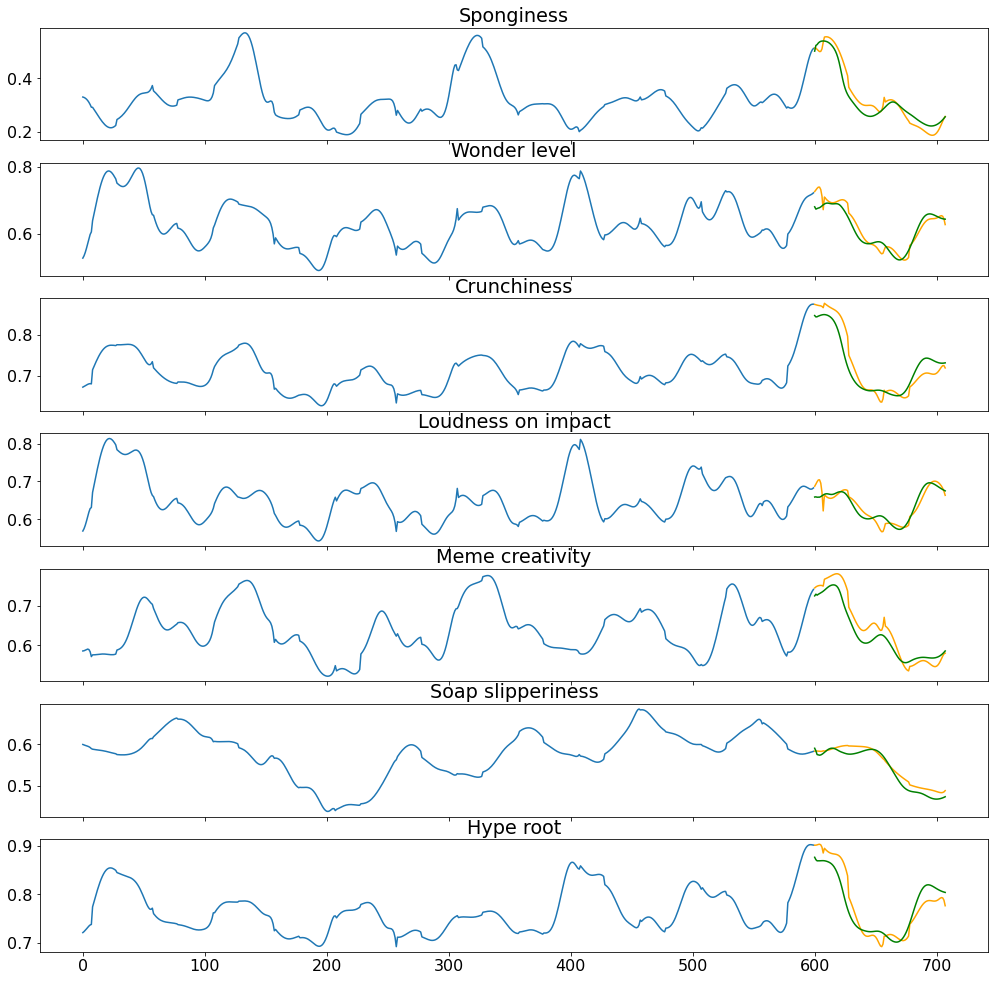

In [ ]:
inspect_multivariate_prediction(x, y, predictions, dataset.columns, telescope)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg  = chunk(normalized_ds, window, reg_telescope, stride)
X_test_reg = X_test_reg[-10:]
y_test_reg = y_test_reg[-10:]
X_test_reg.shape, y_test_reg.shape

((10, 600, 7), (10, 864, 7))

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0054439567>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.04837437>)

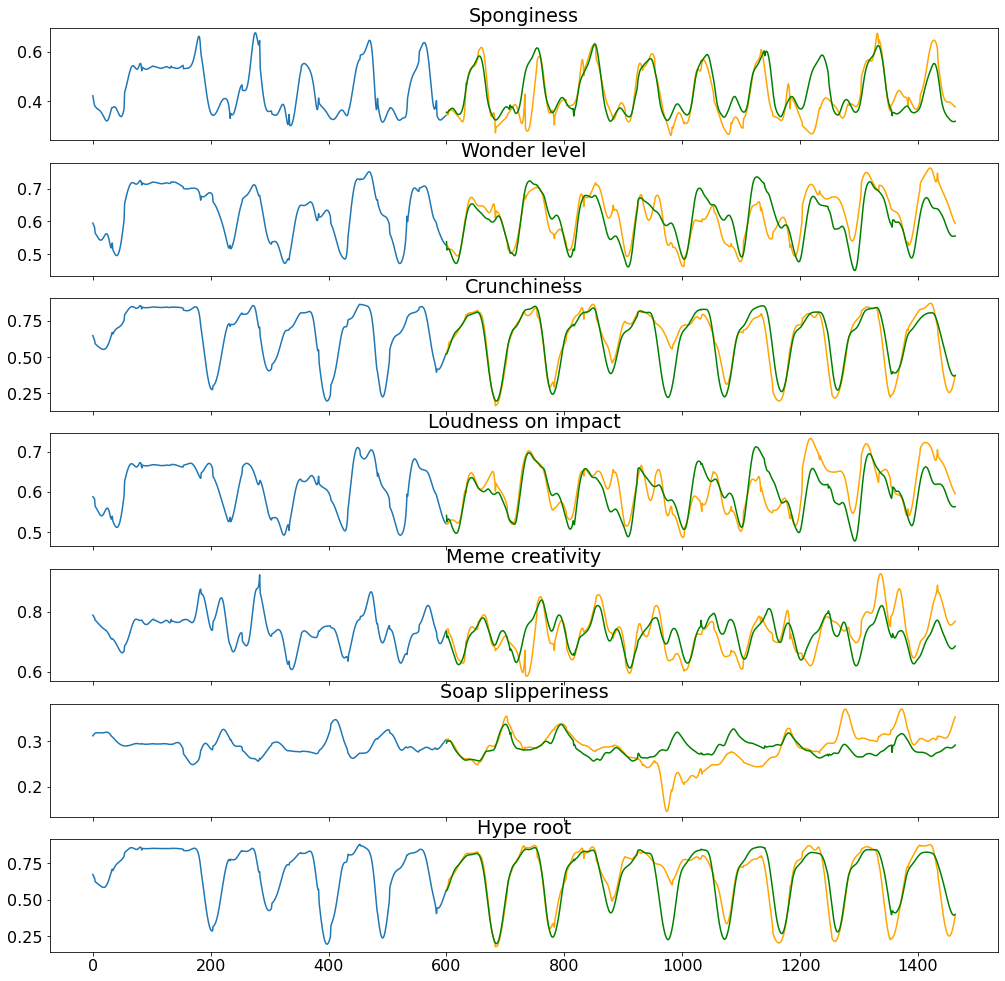

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, dataset.columns, reg_telescope, 8)